### This assignment reads in a data set containg information about car accidents. It then cleans the data and builds some predictive models.

Loading the dataset and importing the necessary libraries

In [1]:
cars = read.csv('c2015.csv')

library(ggplot2)
library(caret)
library(ranger)
library(Assignment14)
library(glmnet)
library(car)

Loading required package: lattice
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: carData


Checking to make sure data was loaded correctly and fixing any columns that were wrongly labeled

In [2]:
str(cars)

cars$AGE=as.integer(cars$AGE)
cars$MOD_YEAR=as.integer(cars$MOD_YEAR)

'data.frame':	80587 obs. of  28 variables:
 $ STATE   : Factor w/ 51 levels "Alabama","Alaska",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ST_CASE : int  10001 10002 10003 10003 10004 10005 10005 10006 10006 10007 ...
 $ VEH_NO  : int  1 1 1 1 1 1 2 1 1 1 ...
 $ PER_NO  : int  1 1 1 2 1 1 1 1 2 1 ...
 $ COUNTY  : int  127 83 11 11 45 45 45 111 111 89 ...
 $ DAY     : int  1 1 1 1 4 7 7 8 8 8 ...
 $ MONTH   : Factor w/ 12 levels "April","August",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ HOUR    : int  2 22 1 1 0 7 7 9 9 18 ...
 $ MINUTE  : int  40 13 25 25 57 9 9 59 59 33 ...
 $ AGE     : Factor w/ 104 levels "1","10","101",..: 68 47 28 16 38 20 60 64 12 82 ...
 $ SEX     : Factor w/ 4 levels "Female","Male",..: 2 2 2 1 2 2 2 2 2 2 ...
 $ PER_TYP : Factor w/ 11 levels "Bicyclist","Driver of a Motor Vehicle In-Transport",..: 2 2 2 6 2 2 2 2 6 2 ...
 $ INJ_SEV : Factor w/ 8 levels "Died Prior to Crash*",..: 2 2 2 6 2 2 4 2 4 2 ...
 $ SEAT_POS: Factor w/ 29 levels "Fourth Seat, Left Side",..: 6 6 6 9 6 6 6 6 9 6 

Pulling out the speed number and convert to an integer

In [3]:
cars$TRAV_SP = substr(cars$TRAV_SP, 1, 4)
cars$TRAV_SP=as.numeric(as.character(cars$TRAV_SP))

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

Removing certain columns from the data to reduce dimensionality and fixing blank values to read as NAs

In [4]:
summary(cars)
cars[cars==""]=NA
cars$DAY=NULL
cars$MINUTE=NULL
cars$YEAR=NULL
cars$LATITUDE=NULL
cars$LONGITUD=NULL
cars$COUNTY=NULL
cars$HARM_EV=NULL

            STATE          ST_CASE           VEH_NO           PER_NO      
 Texas         : 8275   Min.   : 10001   Min.   : 0.000   Min.   : 1.000  
 California    : 7622   1st Qu.:121977   1st Qu.: 1.000   1st Qu.: 1.000  
 Florida       : 7063   Median :270282   Median : 1.000   Median : 1.000  
 Georgia       : 3294   Mean   :275607   Mean   : 1.389   Mean   : 1.629  
 North Carolina: 3121   3rd Qu.:420645   3rd Qu.: 2.000   3rd Qu.: 2.000  
 New York      : 2675   Max.   :560130   Max.   :58.000   Max.   :51.000  
 (Other)       :48537                                                     
     COUNTY            DAY              MONTH            HOUR      
 Min.   :  1.00   Min.   : 1.00   July     : 7672   Min.   : 0.00  
 1st Qu.: 31.00   1st Qu.: 8.00   August   : 7509   1st Qu.: 8.00  
 Median : 71.00   Median :15.00   October  : 7460   Median :15.00  
 Mean   : 91.72   Mean   :15.52   December : 7087   Mean   :14.01  
 3rd Qu.:115.00   3rd Qu.:23.00   September: 7057   3rd Qu.:

[1] 77475

Imputing missing values using a package I built (replaces numeric vars with the mean and categorical vars with the mode.

In [5]:
sum(is.na(cars))
cars_imputed=quick_clean(cars,"impute")
sum(is.na(cars_imputed))

[1] 76140

[1] 0

Recoding categorical columns to further reduce dimensionality

In [7]:
str(cars_imputed)

NE.set=c("Maine","Massachusetts", "Rhode Island", "Connecticut", "New Hampshire", "Vermont", 
     "New York", "Pennsylvania", "New Jersey")
SE.set=c("Delaware", "Maryland","Dist of Columbia", "West Virginia","Virginia", "Kentucky",
     "Tennessee", "North Carolina", "South Carolina", "Georgia", "Alabama", "Mississippi", 
     "Arkansas", "Louisiana", "Florida")
MW.set=c("Ohio", "Indiana", "Michigan", "Illinois", "Missouri", "Wisconsin", "Minnesota", 
     "Iowa", "Kansas", "Nebraska", "South Dakota", "North Dakota")
SW.set=c("Texas", "Oklahoma", "New Mexico", "Arizona")
West.set=c("Colorado", "Wyoming", "Montana", "Idaho", "Washington", "Oregon", "Utah", "Nevada",
       "California", "Alaska", "Hawaii")
cars_imputed$STATE=recode(cars_imputed$STATE,"NE.set='NE'; SE.set='SE'; MW.set='MW'; SW.set='SW'; West.set='West'")

Spring.set=c("March","April","May")
Summer.set=c("June","July","August")
Autumn.set=c("September","October","November")
Winter.set=c("December","January","February")
cars_imputed$MONTH=recode(cars_imputed$MONTH,"Spring.set='Spring'; Summer.set='Summer'; Autumn.set='Autumn'; Winter.set='Winter'")

Bike.set=c("Bicyclist","Other Cyclist")
Bystander.set=c("Pedestrian","Persons In/On Buildings")
Unknown.set=c("Unknown Occupant Type in a Motor Vehicle","Unknown Type of Non-Motorist")
Driver.set=c("Driver of a Motor Vehicle In-Transport", "Persons on Personal Conveyances")
Passenger.set=c("Occupant of a Motor Vehicle Not In- Trans","Occupant of a Non-Motor Vehicle Transport","Passenger of a Motor Vehicle In-Transport")
cars_imputed$PER_TYP=recode(cars_imputed$PER_TYP,"Bike.set='Bike'; Bystander.set='Bystander'; Unknown.set='Unknown'; Driver.set='Driver'; Passenger.set='Passenger'")

Fatal.set=c("Died Prior to Crash*", "Fatal Injury (K)")
Not_Fatal.set=c("Injured, Severity Unknown", "No Apparent Injury (O)","Possible Injury (C)","Suspected Minor Injury(B)","Suspected Serious Injury(A)","Unknown")
cars_imputed$INJ_SEV=recode(cars_imputed$INJ_SEV,"Fatal.set='Fatal';Not_Fatal.set='Not Fatal'")

Front.set=c("Front Seat, Left Side","Front Seat, Middle","Front Seat, Other","Front Seat, Right Side","Front Seat, Unknown","Other Passenger in passenger")
Left.set=c("Fourth Seat, Left Side","Second Seat, Left Side","Third Seat, Left Side")
Middle.set=c("Fourth Seat, Middle","Second Seat, Middle","Third Seat, Middle")
Right.set=c("Fourth Seat, Right Side","Second Seat, Right Side","Third Seat, Right Side")
Back.set=c("Fourth Seat, Other","Fourth Seat, Unknown","Second Seat, Other","Second Seat, Unknown","Sleeper Section of Cab (Truc","Third Seat, Other", "Third Seat, Unknown","Other Passenger in enclosed")
Outside.set=c("Not a Motor Vehicle Occupant","Not Reported","Riding on Exterior of Vehicl","Trailing Unit","Other Passenger in unenclose")
cars_imputed$SEAT_POS=recode(cars_imputed$SEAT_POS,"Front.set='Front';Left.set='Left';Middle.set='Middle';Right.set='Right';Back.set='Back';Outside.set='Outside'")

Cloudy.set=c("Cloud","Fog,","Not R")
Cold.set=c("Freez","Sleet","Snow")
cars_imputed$WEATHER=recode(cars_imputed$WEATHER,"Cloudy.set='Cloudy';Cold.set='Cold'")

'data.frame':	80587 obs. of  21 variables:
 $ STATE   : Factor w/ 51 levels "Alabama","Alaska",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ ST_CASE : num  10001 10002 10003 10003 10004 ...
 $ VEH_NO  : num  1 1 1 1 1 1 2 1 1 1 ...
 $ PER_NO  : num  1 1 1 2 1 1 1 1 2 1 ...
 $ MONTH   : Factor w/ 12 levels "April","August",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ HOUR    : num  2 22 1 1 0 7 7 9 9 18 ...
 $ AGE     : num  68 47 28 16 38 20 60 64 12 82 ...
 $ SEX     : Factor w/ 4 levels "Female","Male",..: 2 2 2 1 2 2 2 2 2 2 ...
 $ PER_TYP : Factor w/ 11 levels "Bicyclist","Driver of a Motor Vehicle In-Transport",..: 2 2 2 6 2 2 2 2 6 2 ...
 $ INJ_SEV : Factor w/ 8 levels "Died Prior to Crash*",..: 2 2 2 6 2 2 4 2 4 2 ...
 $ SEAT_POS: Factor w/ 29 levels "Fourth Seat, Left Side",..: 6 6 6 9 6 6 6 6 9 6 ...
 $ DRINKING: Factor w/ 4 levels "No (Alcohol Not Involved)",..: 3 1 4 2 4 1 1 1 2 2 ...
 $ MAN_COLL: Factor w/ 12 levels "","Angle","Front-to-Front",..: 5 5 5 5 5 2 2 5 5 5 ...
 $ OWNER   : Factor w/ 9 levels

Graphing variables with the target

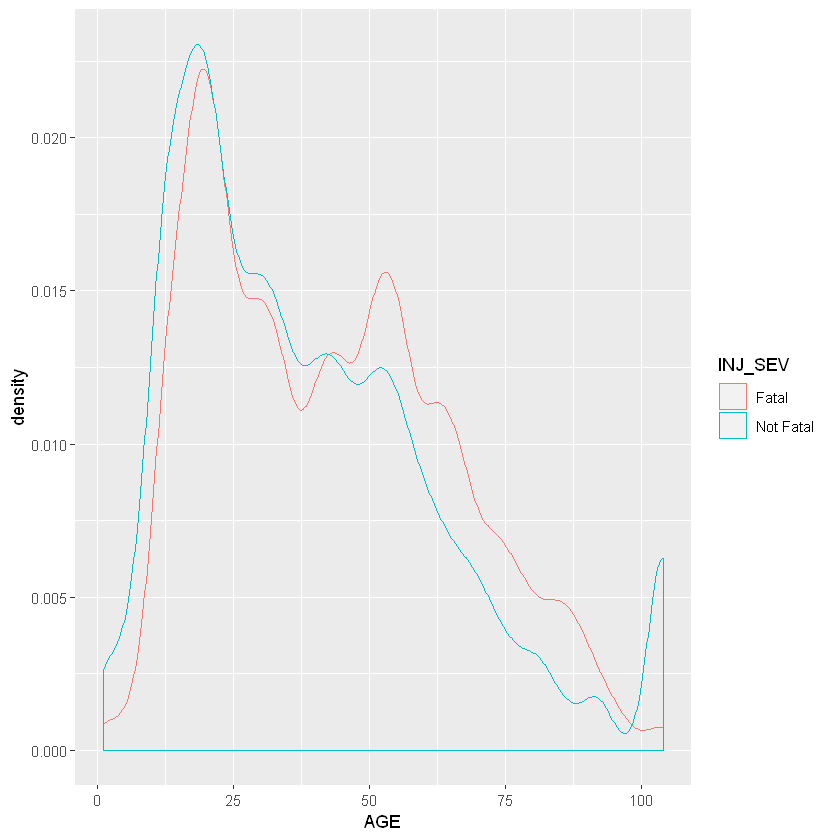

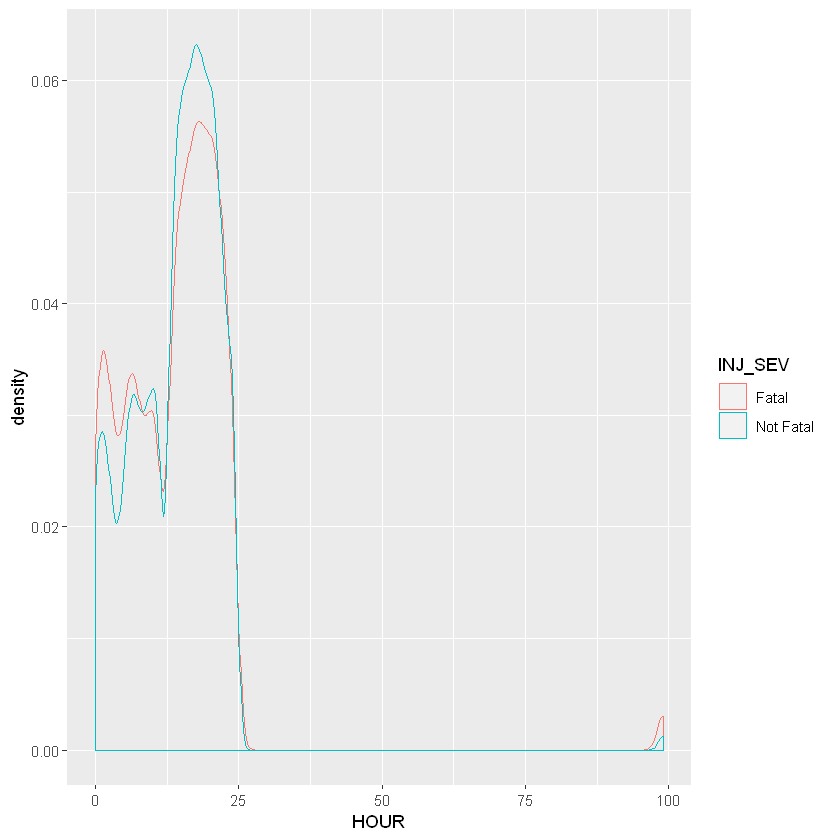

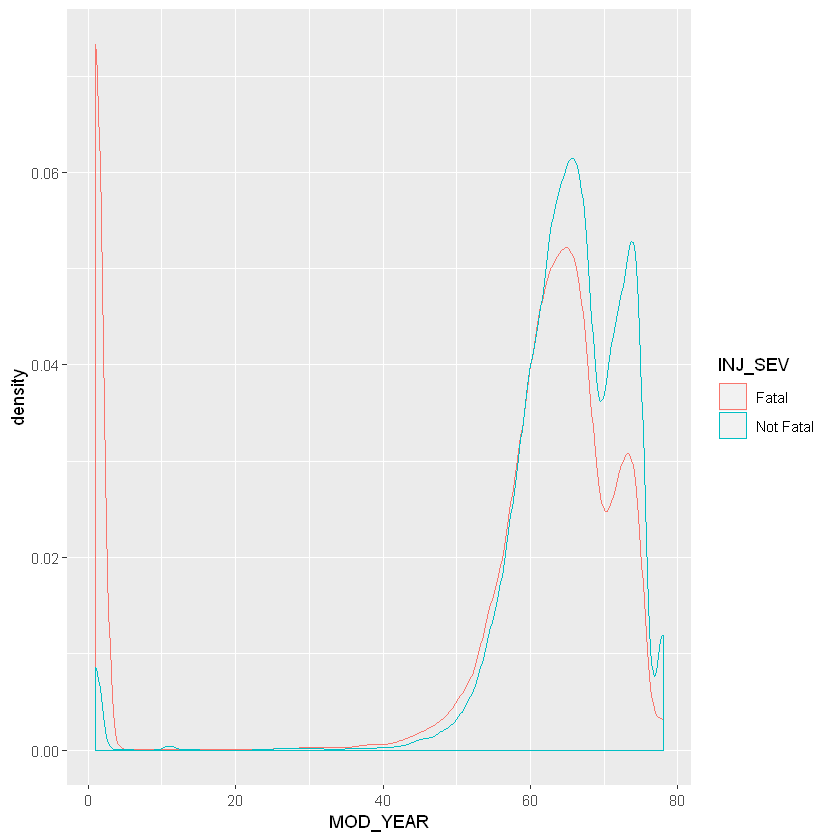

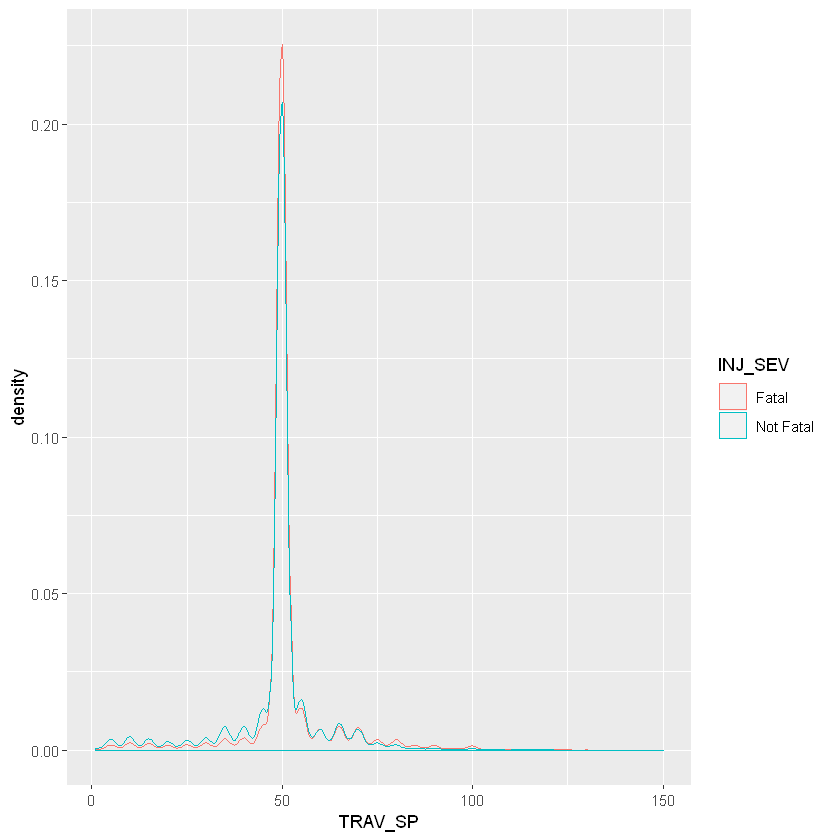

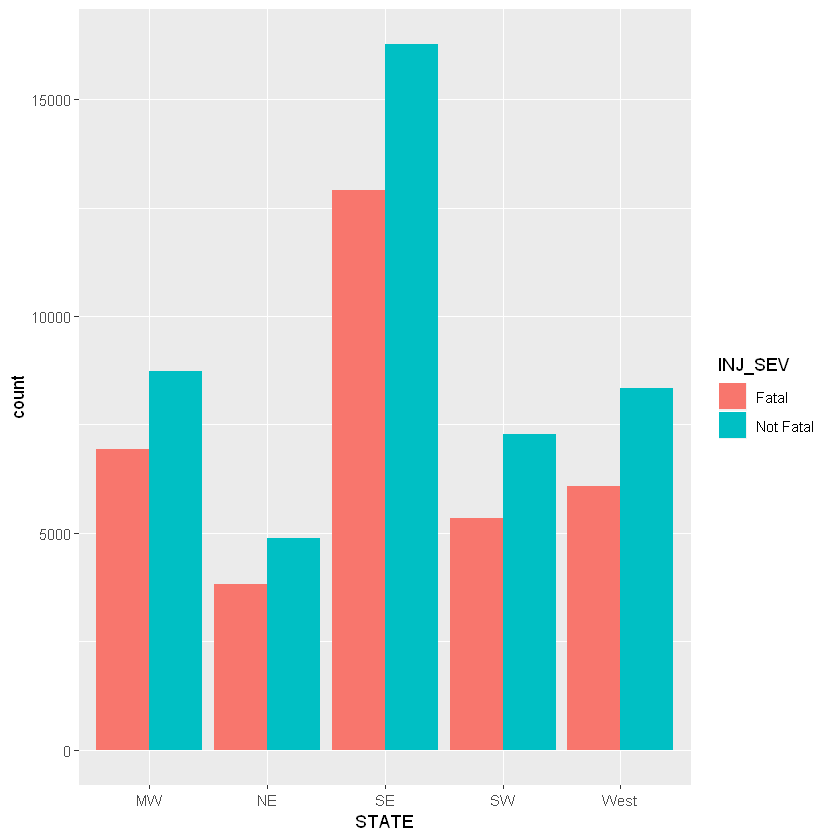

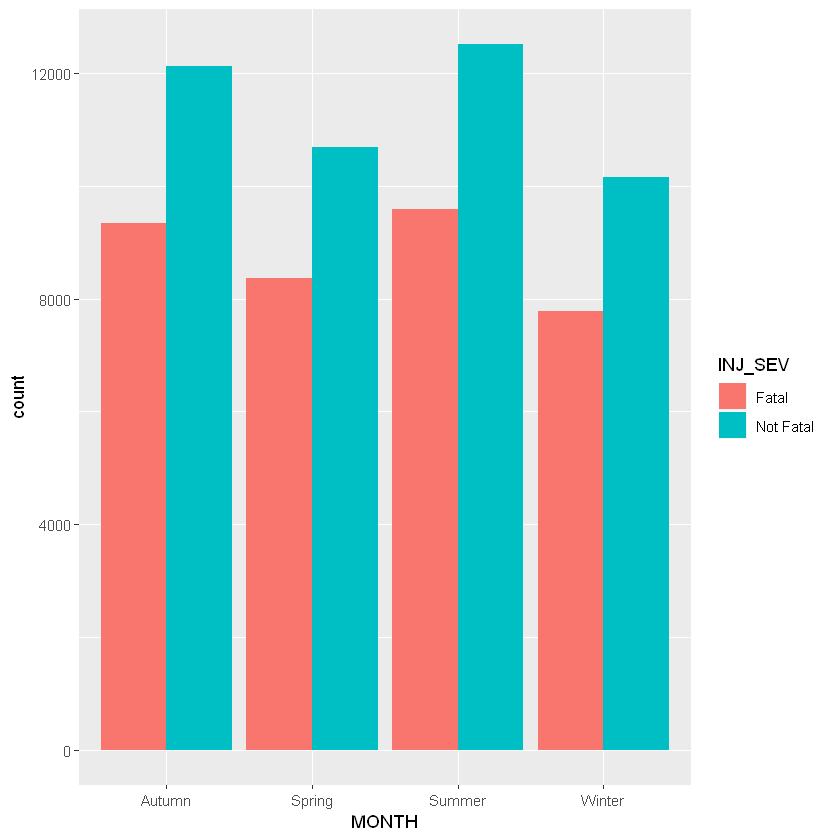

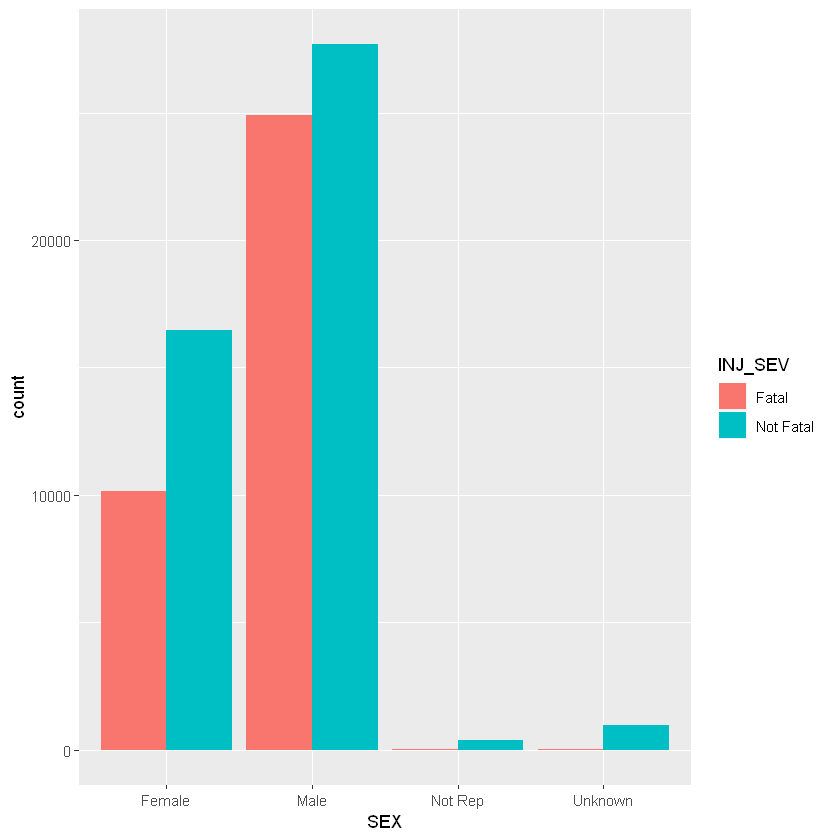

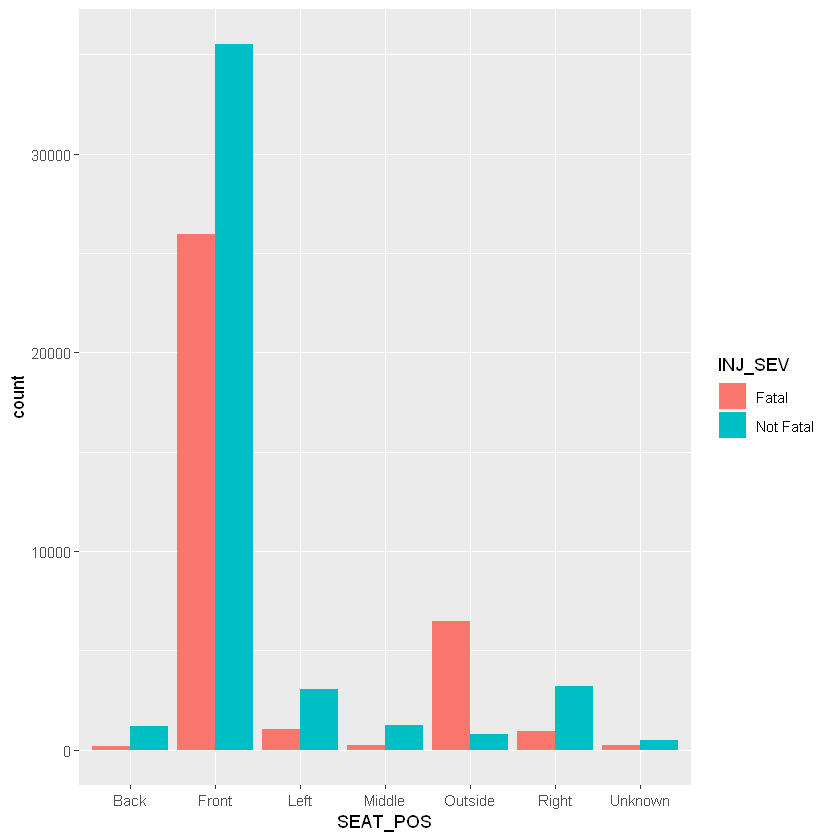

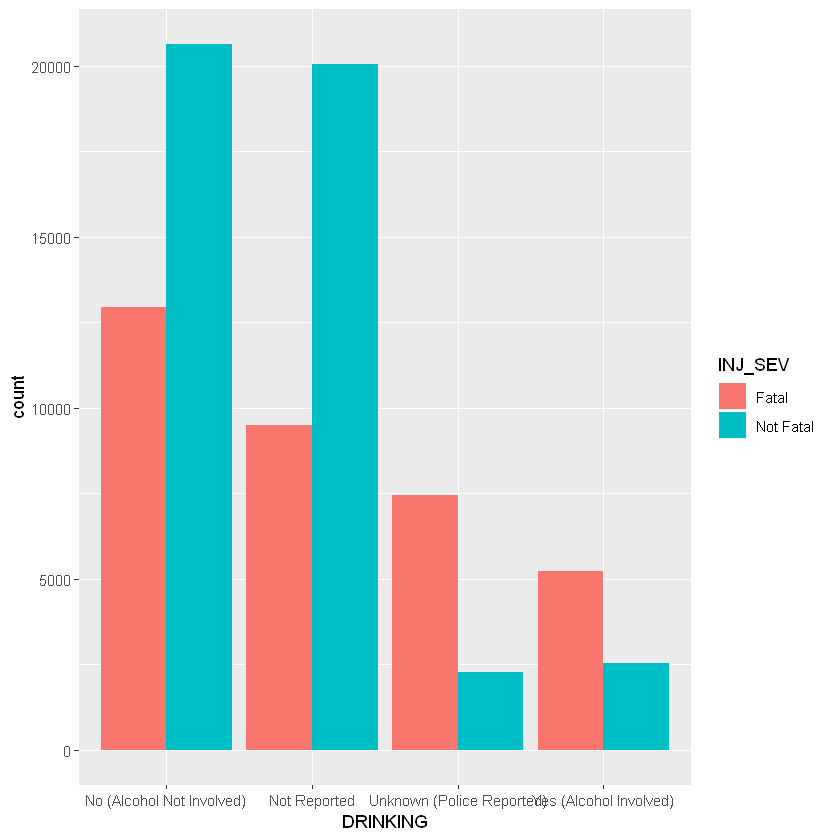

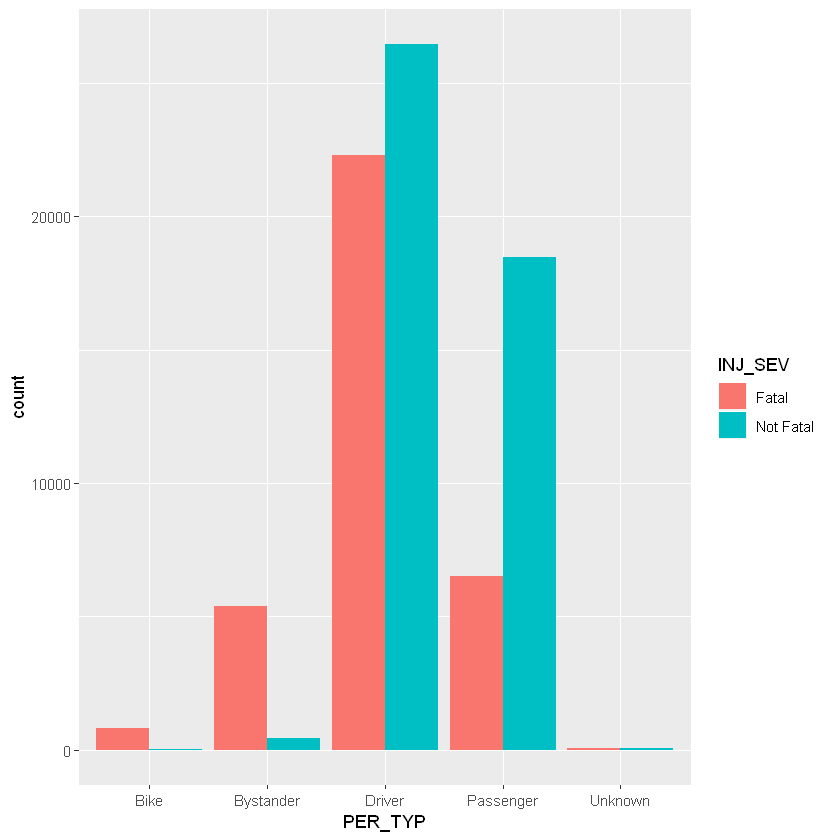

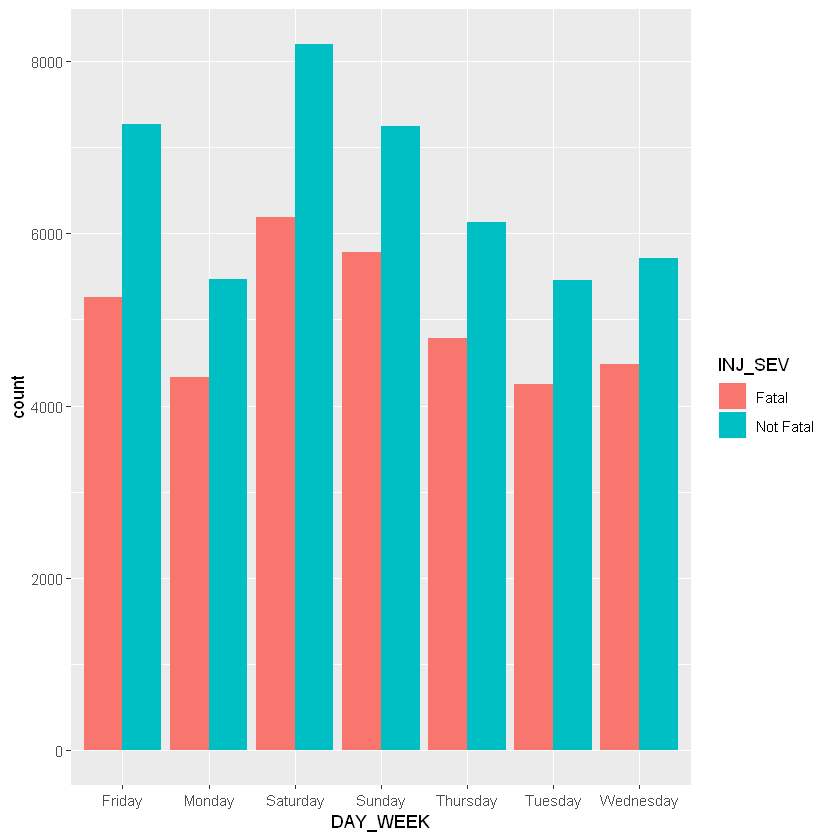

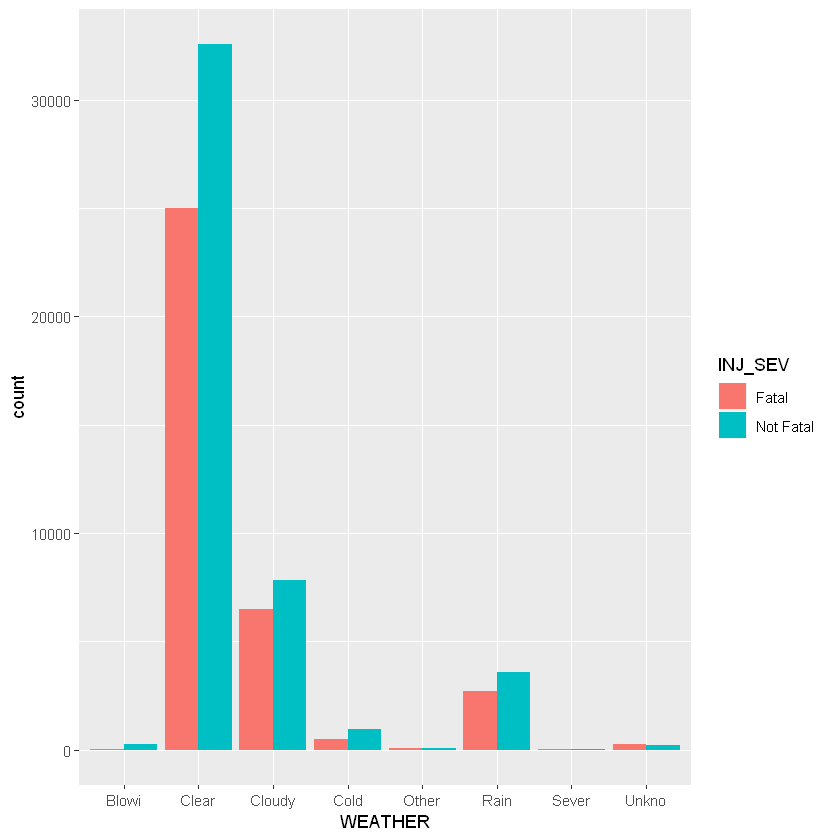

In [8]:
ggplot(data=cars_imputed)+geom_density(mapping=aes(x=AGE,color=INJ_SEV))
ggplot(data=cars_imputed)+geom_density(mapping=aes(x=HOUR,color=INJ_SEV))
ggplot(data=cars_imputed)+geom_density(mapping=aes(x=MOD_YEAR,color=INJ_SEV))
ggplot(data=cars_imputed)+geom_density(mapping=aes(x=TRAV_SP,color=INJ_SEV))
ggplot(data=cars_imputed) + geom_bar(mapping=aes(x=STATE, fill=INJ_SEV), position="dodge")
ggplot(data=cars_imputed) + geom_bar(mapping=aes(x=MONTH, fill=INJ_SEV), position="dodge")
ggplot(data=cars_imputed) + geom_bar(mapping=aes(x=SEX, fill=INJ_SEV), position="dodge")
ggplot(data=cars_imputed) + geom_bar(mapping=aes(x=SEAT_POS, fill=INJ_SEV), position="dodge")
ggplot(data=cars_imputed) + geom_bar(mapping=aes(x=DRINKING, fill=INJ_SEV), position="dodge")
ggplot(data=cars_imputed) + geom_bar(mapping=aes(x=PER_TYP, fill=INJ_SEV), position="dodge")
ggplot(data=cars_imputed) + geom_bar(mapping=aes(x=DAY_WEEK, fill=INJ_SEV), position="dodge")
ggplot(data=cars_imputed) + geom_bar(mapping=aes(x=WEATHER, fill=INJ_SEV), position="dodge")

Encoding the variables and splitting data into train and validation sets

In [9]:
cars_sample=cars_imputed[sample(nrow(cars_imputed),1000),]
dummies_model=dummyVars(INJ_SEV ~ ., data=cars_sample)
trainData=predict(dummies_model, newdata = cars_sample)
trainData= data.frame(trainData)
trainData$INJ_SEV=cars_sample$INJ_SEV

set.seed(2018)
splitIndex=createDataPartition(trainData$INJ_SEV, p=.70, list=FALSE, times=1)
train_cars=trainData[splitIndex,]
test_cars=trainData[-splitIndex,]

Warning message in model.frame.default(Terms, newdata, na.action = na.action, xlev = object$lvls):
"variable 'INJ_SEV' is not a factor"

Building and tuning models

In [10]:
tree1=train(INJ_SEV~.,data=train_cars,method="rpart")
forest1=train(INJ_SEV~.,data=train_cars,method="ranger")

myGrid=expand.grid(mtry=c(1:3),splitrule=c("gini","extratrees"),min.node.size=c(1:4))
myTrain=trainControl(method ="cv", number = 5, verboseIter = TRUE)

tree2=train(INJ_SEV~.,data=train_cars,method="rpart",trControl=myTrain)
forest2=train(INJ_SEV~.,data=train_cars,method="ranger",trControl=myTrain,tuneGrid=myGrid)

myGrid2=expand.grid(mtry=2,splitrule="gini",min.node.size=c(1:3))
myTrain2=trainControl(method ="cv", number = 10, verboseIter = TRUE)

tree3=train(INJ_SEV~.,data=train_cars,method="rpart",trControl=myTrain2)
forest3=train(INJ_SEV~.,data=train_cars,method="ranger",trControl=myTrain2,tuneGrid=myGrid2)

myGrid3=expand.grid(.alpha=0:1,.lambda=seq(0.001,1,length=10))

glm=train(INJ_SEV~.,data=train_cars, method="glmnet")
glm2=train(INJ_SEV~.,data=train_cars, method="glmnet", tuneGrid=myGrid3)

+ Fold1: cp=0.0363 
- Fold1: cp=0.0363 
+ Fold2: cp=0.0363 
- Fold2: cp=0.0363 
+ Fold3: cp=0.0363 
- Fold3: cp=0.0363 
+ Fold4: cp=0.0363 
- Fold4: cp=0.0363 
+ Fold5: cp=0.0363 
- Fold5: cp=0.0363 
Aggregating results
Selecting tuning parameters
Fitting cp = 0.0363 on full training set
+ Fold1: mtry=1, splitrule=gini, min.node.size=1 
- Fold1: mtry=1, splitrule=gini, min.node.size=1 
+ Fold1: mtry=2, splitrule=gini, min.node.size=1 
- Fold1: mtry=2, splitrule=gini, min.node.size=1 
+ Fold1: mtry=3, splitrule=gini, min.node.size=1 
- Fold1: mtry=3, splitrule=gini, min.node.size=1 
+ Fold1: mtry=1, splitrule=extratrees, min.node.size=1 
- Fold1: mtry=1, splitrule=extratrees, min.node.size=1 
+ Fold1: mtry=2, splitrule=extratrees, min.node.size=1 
- Fold1: mtry=2, splitrule=extratrees, min.node.size=1 
+ Fold1: mtry=3, splitrule=extratrees, min.node.size=1 
- Fold1: mtry=3, splitrule=extratrees, min.node.size=1 
+ Fold1: mtry=1, splitrule=gini, min.node.size=2 
- Fold1: mtry=1, splitrul

Comparing model performance on testing data and pulling out the model with the highest balanced accuracy score

In [11]:
models=list(tree1,forest1,tree2,forest2,tree3,forest3,glm,glm2)
compare=c()
prediction=function(x){
  pred=predict(x,test_cars)
  cm=confusionMatrix(pred,test_cars$INJ_SEV,positive="Not Fatal")
  compare=c(compare,cm$byClass['Balanced Accuracy'])
}

accuracies=sapply(models,prediction)
best=max(accuracies)
index=match(best,accuracies)
models[[index]]
best

Random Forest 

701 samples
 95 predictor
  2 classes: 'Fatal', 'Not Fatal' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 701, 701, 701, 701, 701, 701, ... 
Resampling results across tuning parameters:

  mtry  splitrule   Accuracy   Kappa    
   2    gini        0.6711650  0.2734325
   2    extratrees  0.6680849  0.2643936
  48    gini        0.7231675  0.4261277
  48    extratrees  0.7074592  0.3957860
  95    gini        0.7097087  0.4006938
  95    extratrees  0.7008886  0.3836815

Tuning parameter 'min.node.size' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 48, splitrule = gini
 and min.node.size = 1.

[1] 0.718901